In [1]:
import pybaseball
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az

In [2]:
data = pybaseball.statcast('2020-07-20','2020-09-30')

This is a large query, it may take a moment to complete
Completed sub-query from 2020-07-20 to 2020-07-25
Completed sub-query from 2020-07-26 to 2020-07-31
Completed sub-query from 2020-08-01 to 2020-08-06
Completed sub-query from 2020-08-07 to 2020-08-12
Completed sub-query from 2020-08-13 to 2020-08-18
Completed sub-query from 2020-08-19 to 2020-08-24
Completed sub-query from 2020-08-25 to 2020-08-30
Completed sub-query from 2020-08-31 to 2020-09-05
Completed sub-query from 2020-09-06 to 2020-09-11
Completed sub-query from 2020-09-12 to 2020-09-17
Completed sub-query from 2020-09-18 to 2020-09-23
Completed sub-query from 2020-09-24 to 2020-09-29
Completed sub-query from 2020-09-30 to 2020-09-30


In [3]:
df_bbe = data[data['type'] == "X"]
df_bbe.columns

Index(['index', 'pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
     

In [4]:
len(df_bbe)

44562

dependend variable: is_barrel (obtained from launch_speed_angle)

control variables (dummies): pitch_type, zone, opp_stance (obtained from stand and p_throws), count (obtained from balls and strikes)

control variables (continuous): release_speed, release_pos_x (absolute value), release_pos_z, pfx_x, pfx_z, plate_x (absolute value), plate_z, vx0, vy0, vz0, ax, ay, az, sz_top, sz_bot, release_spin_rate, release_extension (release_pos_y is the opposite)

In [5]:
df_bbe = df_bbe.drop(['index','game_date','player_name','batter','pitcher','events','description','des','game_type','home_team','away_team','type','hit_location','bb_type','game_year','on_3b','on_2b','on_1b','outs_when_up','inning','inning_topbot','hc_x','hc_y','fielder_2','umpire','sv_id','hit_distance_sc','launch_speed','launch_angle','effective_speed','game_pk','pitcher.1','fielder_2.1','fielder_3',"fielder_4",'fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','estimated_ba_using_speedangle','estimated_woba_using_speedangle','woba_value','woba_denom','babip_value','iso_value','at_bat_number','pitch_number','pitch_name','home_score','away_score','bat_score','fld_score','post_away_score','post_home_score','post_bat_score','post_fld_score','if_fielding_alignment','of_fielding_alignment','spin_dir','spin_rate_deprecated','break_angle_deprecated','break_length_deprecated','tfs_deprecated','tfs_zulu_deprecated'],axis=1)

In [6]:
df_bbe.columns

Index(['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone',
       'stand', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'release_spin_rate', 'release_extension', 'release_pos_y',
       'launch_speed_angle'],
      dtype='object')

In [7]:
df_bbe['release_pos_x_abs'] = df_bbe['release_pos_x'].apply(abs)
df_bbe['plate_x_abs'] = df_bbe['plate_x'].apply(abs)

<AxesSubplot:>

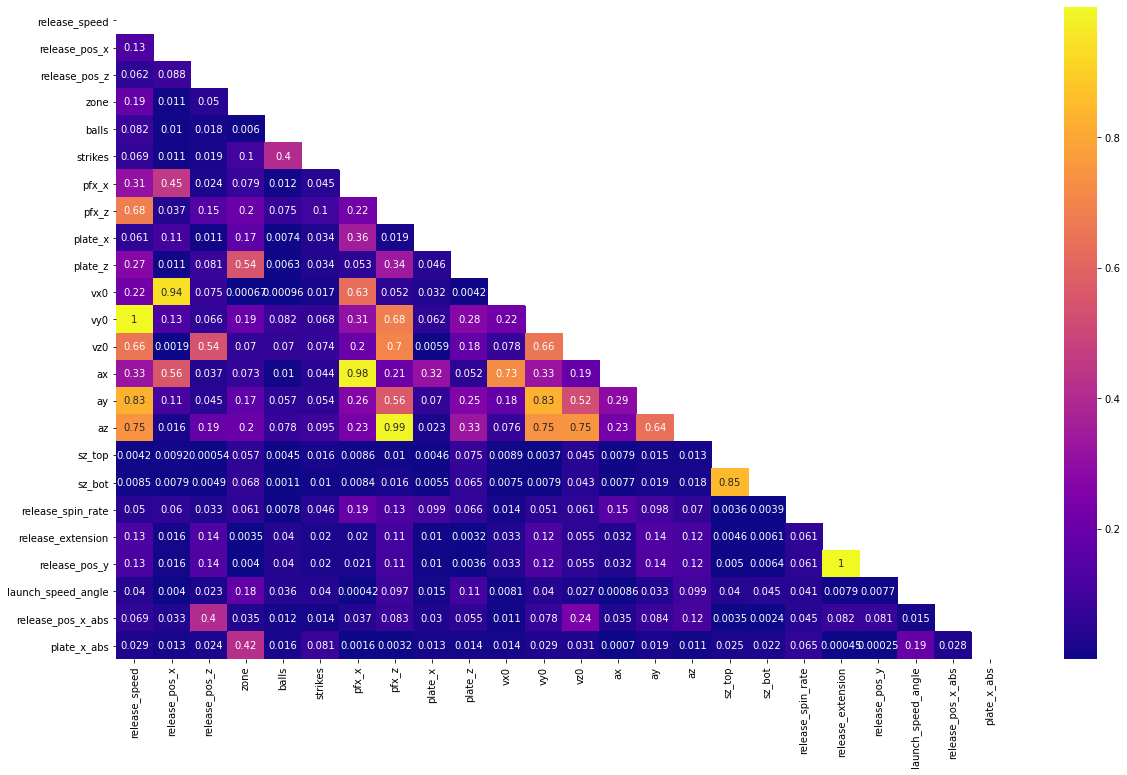

In [8]:
plt.figure(figsize=(20,12))
sns.heatmap(df_bbe.corr().abs(),mask=np.tri(*df_bbe.corr().shape).T ,annot=True,cmap='plasma')

unused variables: release_speed (the same as vy0), release_extension (same as release_pos_y), pfx_x (close to ax), pfx_z (close to az)

In [9]:
df_bbe['opp_stance'] = (df_bbe['stand'] != df_bbe['p_throws']).astype(int)

In [10]:
df_bbe['count_10'] = ((df_bbe['balls'] == 1) & (df_bbe['strikes'] == 0)).astype(int)
df_bbe['count_20'] = ((df_bbe['balls'] == 2) & (df_bbe['strikes'] == 0)).astype(int)
df_bbe['count_30'] = ((df_bbe['balls'] == 3) & (df_bbe['strikes'] == 0)).astype(int)
df_bbe['count_01'] = ((df_bbe['balls'] == 0) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_11'] = ((df_bbe['balls'] == 1) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_21'] = ((df_bbe['balls'] == 2) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_31'] = ((df_bbe['balls'] == 3) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_02'] = ((df_bbe['balls'] == 0) & (df_bbe['strikes'] == 2)).astype(int)
df_bbe['count_12'] = ((df_bbe['balls'] == 1) & (df_bbe['strikes'] == 2)).astype(int)
df_bbe['count_22'] = ((df_bbe['balls'] == 2) & (df_bbe['strikes'] == 2)).astype(int)
df_bbe['count_32'] = ((df_bbe['balls'] == 3) & (df_bbe['strikes'] == 2)).astype(int)

In [11]:
df_bbe = df_bbe.join(pd.get_dummies(df_bbe['pitch_type']))

In [12]:
col_dict = {}
keys = np.arange(1,15,dtype=float)
values = []
for i in range(1,15): values.append('zone_'+str(i))
col_dict = dict(zip(keys,values))
df_bbe = df_bbe.join(pd.get_dummies(df_bbe['zone']).rename(columns=col_dict))

In [13]:
df_bbe['is_barrel'] = (df_bbe['launch_speed_angle'] == float(6)).astype(int)

In [14]:
df_bbe.columns

Index(['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone',
       'stand', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'release_spin_rate', 'release_extension', 'release_pos_y',
       'launch_speed_angle', 'release_pos_x_abs', 'plate_x_abs', 'opp_stance',
       'count_10', 'count_20', 'count_30', 'count_01', 'count_11', 'count_21',
       'count_31', 'count_02', 'count_12', 'count_22', 'count_32', 'CH', 'CS',
       'CU', 'FC', 'FF', 'FO', 'FS', 'KC', 'KN', 'SI', 'SL', 'zone_1',
       'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8',
       'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'is_barrel'],
      dtype='object')

Scaling some variables

In [15]:
df_bbe['release_spin_rate_sc'] = df_bbe['release_spin_rate']/1000
df_bbe['plate_x_sc'] = df_bbe['plate_x']*10
df_bbe['vy0_sc'] = df_bbe['vy0']/100
df_bbe['ay_sc'] = df_bbe['ay']/10
df_bbe['az_sc'] = df_bbe['az']/10
df_bbe['release_pos_y_sc'] = df_bbe['release_pos_y']/10

Variable groups

some variables: vx0, vy0, vz0, ax, ay, az, sz_top, sz_bot, release_pos_x_abs, release_pos_z, release_pos_y, plate_x_abs, plate_z, release_spin_rate, opp_stance

pfx_x and pfx_z (breakx and breakz) high corr. with ax and az

pitch type dummies or continuous variables?
most important cont. variables for pitch classification in order (Fonnesbeck): pfx_x, vy0, pfx_z (747), release_spin_rate (661), release_pos_z (426), release_pos_x (340), pitcher height, release_pos_y
https://github.com/fonnesbeck/baseball/blob/master/notebooks/Pitch%20Classification.ipynb

zone dummies or sz_top and sz_bot?

include count or not?

start with the 4 most important variables (Fonnesbeck): pfx_x, vy0, pfx_z, release_spin_rate

In [16]:
bbe_sample = df_bbe.sample(5000,random_state=123).round(3)
chain_n = 2
chain_len = 2000
burn_in = int(chain_len/2)
del data, df_bbe
bbe_sample.head()

,pitch_type,release_speed,release_pos_x,release_pos_z,zone,stand,p_throws,balls,strikes,pfx_x,...,zone_12,zone_13,zone_14,is_barrel,release_spin_rate_sc,plate_x_sc,vy0_sc,ay_sc,az_sc,release_pos_y_sc
98061,CH,82.3,-0.36,6.47,14.0,R,R,0.0,2.0,-1.10,...,0,0,1,0,1.624,3.7,-1.198,2.285,-2.847,5.462
172314,SL,81.7,1.73,6.23,1.0,L,L,1.0,2.0,-0.50,...,0,0,0,0,2.150,-4.6,-1.190,2.411,-2.619,5.450
125059,CU,79.9,-2.63,5.48,6.0,R,R,0.0,1.0,0.17,...,0,0,0,0,2.327,3.3,-1.162,2.202,-3.168,5.468
234493,FF,91.3,-2.39,5.74,8.0,L,R,0.0,0.0,-0.87,...,0,0,0,0,2.239,-1.2,-1.327,2.543,-1.731,5.453
225806,SL,79.6,-2.11,6.18,8.0,L,R,2.0,1.0,0.07,...,0,0,0,0,2.453,-1.5,-1.160,1.860,-3.089,5.443


In [17]:
len(bbe_sample)

5000

In [18]:
with pm.Model() as model1:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace1 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 390 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.495,0.605,-4.573,-2.239,0.021,0.015,813.0,813.0,824.0,988.0,1.00
pfx_x,0.067,0.060,-0.042,0.184,0.002,0.001,1616.0,1524.0,1618.0,1628.0,1.00
pfx_z,0.282,0.094,0.110,0.464,0.003,0.002,894.0,856.0,902.0,1320.0,1.00
vy0_sc,0.084,0.414,-0.693,0.942,0.015,0.011,782.0,692.0,884.0,803.0,1.01
release_spin_rate_sc,0.409,0.169,0.096,0.740,0.005,0.004,990.0,990.0,992.0,1136.0,1.00
scale,0.456,0.361,0.040,1.019,0.012,0.009,901.0,901.0,773.0,1109.0,1.01


Velocity and acceleration cont. variables vs pitch type dummies

In [20]:
with pm.Model() as model_2:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + release_spin_rate_sc + vx0 + vy0_sc + vz0 + ax + ay_sc + az_sc + release_pos_x_abs + release_pos_z',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace2 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)
print(az.summary(trace2))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [release_pos_z, release_pos_x_abs, az_sc, ay_sc, ax, vz0, vy0_sc, vx0, release_spin_rate_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 949 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -2.434  1.092  -4.598   -0.499      0.028    0.020   
pfx_x                 0.004  0.185  -0.373    0.365      0.004    0.004   
pfx_z                 0.039  0.197  -0.333    0.424      0.005    0.004   
release_spin_rate_sc  0.236  0.159  -0.033    0.531      0.003    0.002   
vx0                   0.019  0.016  -0.012    0.046      0.000    0.000   
vy0_sc               -0.025  0.243  -0.533    0.418      0.005    0.005   
vz0                   0.110  0.040   0.030    0.183      0.001    0.001   
ax                    0.013  0.019  -0.023    0.048      0.000    0.000   
ay_sc                 0.016  0.129  -0.221    0.268      0.002    0.002   
az_sc                 0.421  0.215  -0.013    0.793      0.006    0.004   
release_pos_x_abs    -0.100  0.074  -0.235    0.038      0.001    0.001   
release_pos_z         0.151  0.126  -0.052    0.407      0.003    0.002   
scale                 0.1

In [21]:
# get rid of pitches KC FS EP KN SC
with pm.Model() as model_3:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + FF + CH + SL + FC + CU + SI + FS',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace3 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)
print(az.summary(trace3))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [FS, SI, CU, FC, SL, CH, FF, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 509 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -2.805  0.540  -3.770   -1.715      0.015    0.010   
pfx_x                 0.063  0.063  -0.051    0.182      0.001    0.001   
pfx_z                 0.195  0.118  -0.026    0.410      0.003    0.002   
vy0_sc                0.074  0.316  -0.495    0.762      0.009    0.008   
release_spin_rate_sc  0.143  0.156  -0.125    0.449      0.003    0.002   
FF                    0.108  0.170  -0.189    0.463      0.004    0.003   
CH                   -0.558  0.253  -1.008   -0.067      0.008    0.006   
SL                   -0.112  0.167  -0.449    0.187      0.004    0.003   
FC                   -0.026  0.170  -0.366    0.304      0.004    0.003   
CU                    0.105  0.188  -0.225    0.484      0.004    0.004   
SI                   -0.109  0.160  -0.429    0.175      0.004    0.003   
FS                    0.094  0.243  -0.327    0.609      0.005    0.005   
scale                 0.2

In [22]:
waic1 = az.compare({'base':trace1,'contvars':trace2,'pitchdummies':trace3},ic='waic')
print(waic1)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


             rank     waic   p_waic   d_waic    weight       se      dse  \
contvars        0 -1332.24   7.7669        0  0.561515  47.7544        0   
pitchdummies    1 -1333.27  7.86334  1.03351  0.412552  47.8829  3.84777   
base            2 -1337.27  4.17819  5.03386  0.025933   47.637  3.01407   

             warning waic_scale  
contvars       False        log  
pitchdummies   False        log  
base           False        log  


In [23]:
with pm.Model() as model4:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + sz_top + sz_bot',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace4 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sz_bot, sz_top, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 242 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [24]:
with pm.Model() as model5:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace5 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 260 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
with pm.Model() as model6:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + sz_top + sz_bot + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace6 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, sz_bot, sz_top, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 735 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
waic2 = az.compare({'base':trace1,'sz_topbot':trace4,'zonedummies':trace5,'zone_topbot':trace6},ic='waic')
print(waic2)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


            rank     waic   p_waic    d_waic       weight       se      dse  \
zone_topbot    0 -1299.81  14.9654         0     0.645448  45.6164        0   
zonedummies    1 -1300.73   13.634  0.918551     0.354552  45.6251  1.74454   
sz_topbot      2 -1336.63   5.0292   36.8249  5.50948e-09  44.4435  7.69359   
base           3 -1337.27  4.17819   37.4668  3.35344e-09  44.4676  7.81367   

            warning waic_scale  
zone_topbot   False        log  
zonedummies   False        log  
sz_topbot     False        log  
base          False        log  


Count? Opp stance?

In [27]:
with pm.Model() as model7:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace7 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 181 seconds.


In [28]:
with pm.Model() as model8:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + opp_stance',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace8 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [opp_stance, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 175 seconds.
The acceptance probability does not match the target. It is 0.8815796846017696, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
with pm.Model() as model9:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + opp_stance + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace9 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, opp_stance, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 170 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [30]:
waic3 = az.compare({'base':trace1,'countdummies':trace7,'opp_stance':trace8,'count_stance':trace9},ic='waic')
print(waic3)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


             rank     waic   p_waic   d_waic     weight       se      dse  \
count_stance    0 -1331.95  11.4733        0   0.610935  47.1436        0   
countdummies    1 -1333.14  10.7807  1.18627   0.260928  46.8817  1.65503   
opp_stance      2 -1336.42  5.31332  4.46655  0.0837131  47.2084  3.44586   
base            3 -1337.27  4.17819  5.32498  0.0444235  46.8871  3.82929   

             warning waic_scale  
count_stance   False        log  
countdummies   False        log  
opp_stance     False        log  
base           False        log  


In [31]:
with pm.Model() as model10:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9 + sz_top + sz_bot + FF + CH + SL + FC + CU + SI + FS + vx0 + vy0_sc + vz0 + ax + ay_sc + az_sc + release_pos_x_abs + release_pos_z + opp_stance + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace10 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, opp_stance, release_pos_z, release_pos_x_abs, az_sc, ay_sc, ax, vz0, vx0, FS, SI, CU, FC, SL, CH, FF, sz_bot, sz_top, zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 643 seconds.
There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [32]:
with pm.Model() as model11:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + release_spin_rate_sc + vx0 + vy0_sc + vz0 + ax + ay_sc + az_sc + release_pos_x_abs + release_pos_z + sz_top + sz_bot + opp_stance + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9 + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace11 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, opp_stance, sz_bot, sz_top, release_pos_z, release_pos_x_abs, az_sc, ay_sc, ax, vz0, vy0_sc, vx0, release_spin_rate_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 770 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [33]:
waic4 = az.compare({'base':trace1,'zone_topbot':trace6,'all_variables':trace10,'count_stance':trace9,'contvars':trace2,'selection':trace11},ic='waic')
print(waic4)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


              rank     waic   p_waic   d_waic       weight       se      dse  \
zone_topbot      0 -1299.81  14.9654        0     0.777082  44.0391        0   
selection        1 -1304.52  24.8379  4.71604     0.114773  44.7649  4.84523   
all_variables    2 -1305.28  26.8082   5.4743     0.108145  44.1915  5.48322   
count_stance     3 -1331.95  11.4733  32.1418  1.45008e-07  44.8905   8.4905   
contvars         4 -1332.24   7.7669  32.4329   9.7705e-08  44.5192  7.61433   
base             5 -1337.27  4.17819  37.4668  6.66153e-09   43.717  7.81367   

              warning waic_scale  
zone_topbot     False        log  
selection       False        log  
all_variables   False        log  
count_stance    False        log  
contvars        False        log  
base            False        log  


In [34]:
trace6_sum = az.summary(trace6)
print(trace6_sum)

                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -6.076  1.377  -8.686   -3.566      0.036    0.025   
pfx_x                 0.057  0.065  -0.070    0.174      0.001    0.001   
pfx_z                 0.223  0.098   0.043    0.417      0.003    0.002   
vy0_sc                0.301  0.627  -0.795    1.630      0.018    0.013   
release_spin_rate_sc  0.353  0.172   0.031    0.673      0.004    0.003   
sz_top                0.388  0.426  -0.332    1.236      0.011    0.008   
sz_bot                0.506  0.728  -0.828    1.937      0.018    0.014   
zone_1                0.791  0.330   0.187    1.400      0.009    0.007   
zone_2                1.347  0.266   0.870    1.866      0.008    0.006   
zone_3                1.049  0.342   0.400    1.682      0.010    0.007   
zone_4                0.927  0.262   0.442    1.412      0.008    0.006   
zone_5                1.431  0.234   1.009    1.874      0.008    0.006   
zone_6                1.2

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'pfx_x'}>,
        <AxesSubplot:title={'center':'pfx_x'}>],
       [<AxesSubplot:title={'center':'pfx_z'}>,
        <AxesSubplot:title={'center':'pfx_z'}>],
       [<AxesSubplot:title={'center':'vy0_sc'}>,
        <AxesSubplot:title={'center':'vy0_sc'}>],
       [<AxesSubplot:title={'center':'release_spin_rate_sc'}>,
        <AxesSubplot:title={'center':'release_spin_rate_sc'}>],
       [<AxesSubplot:title={'center':'sz_top'}>,
        <AxesSubplot:title={'center':'sz_top'}>],
       [<AxesSubplot:title={'center':'sz_bot'}>,
        <AxesSubplot:title={'center':'sz_bot'}>],
       [<AxesSubplot:title={'center':'zone_1'}>,
        <AxesSubplot:title={'center':'zone_1'}>],
       [<AxesSubplot:title={'center':'zone_2'}>,
        <AxesSubplot:title={'center':'zone_2'}>],
       [<AxesSubplot:title={'center':'zone_3'}>,
        <AxesSubplot:title={'c

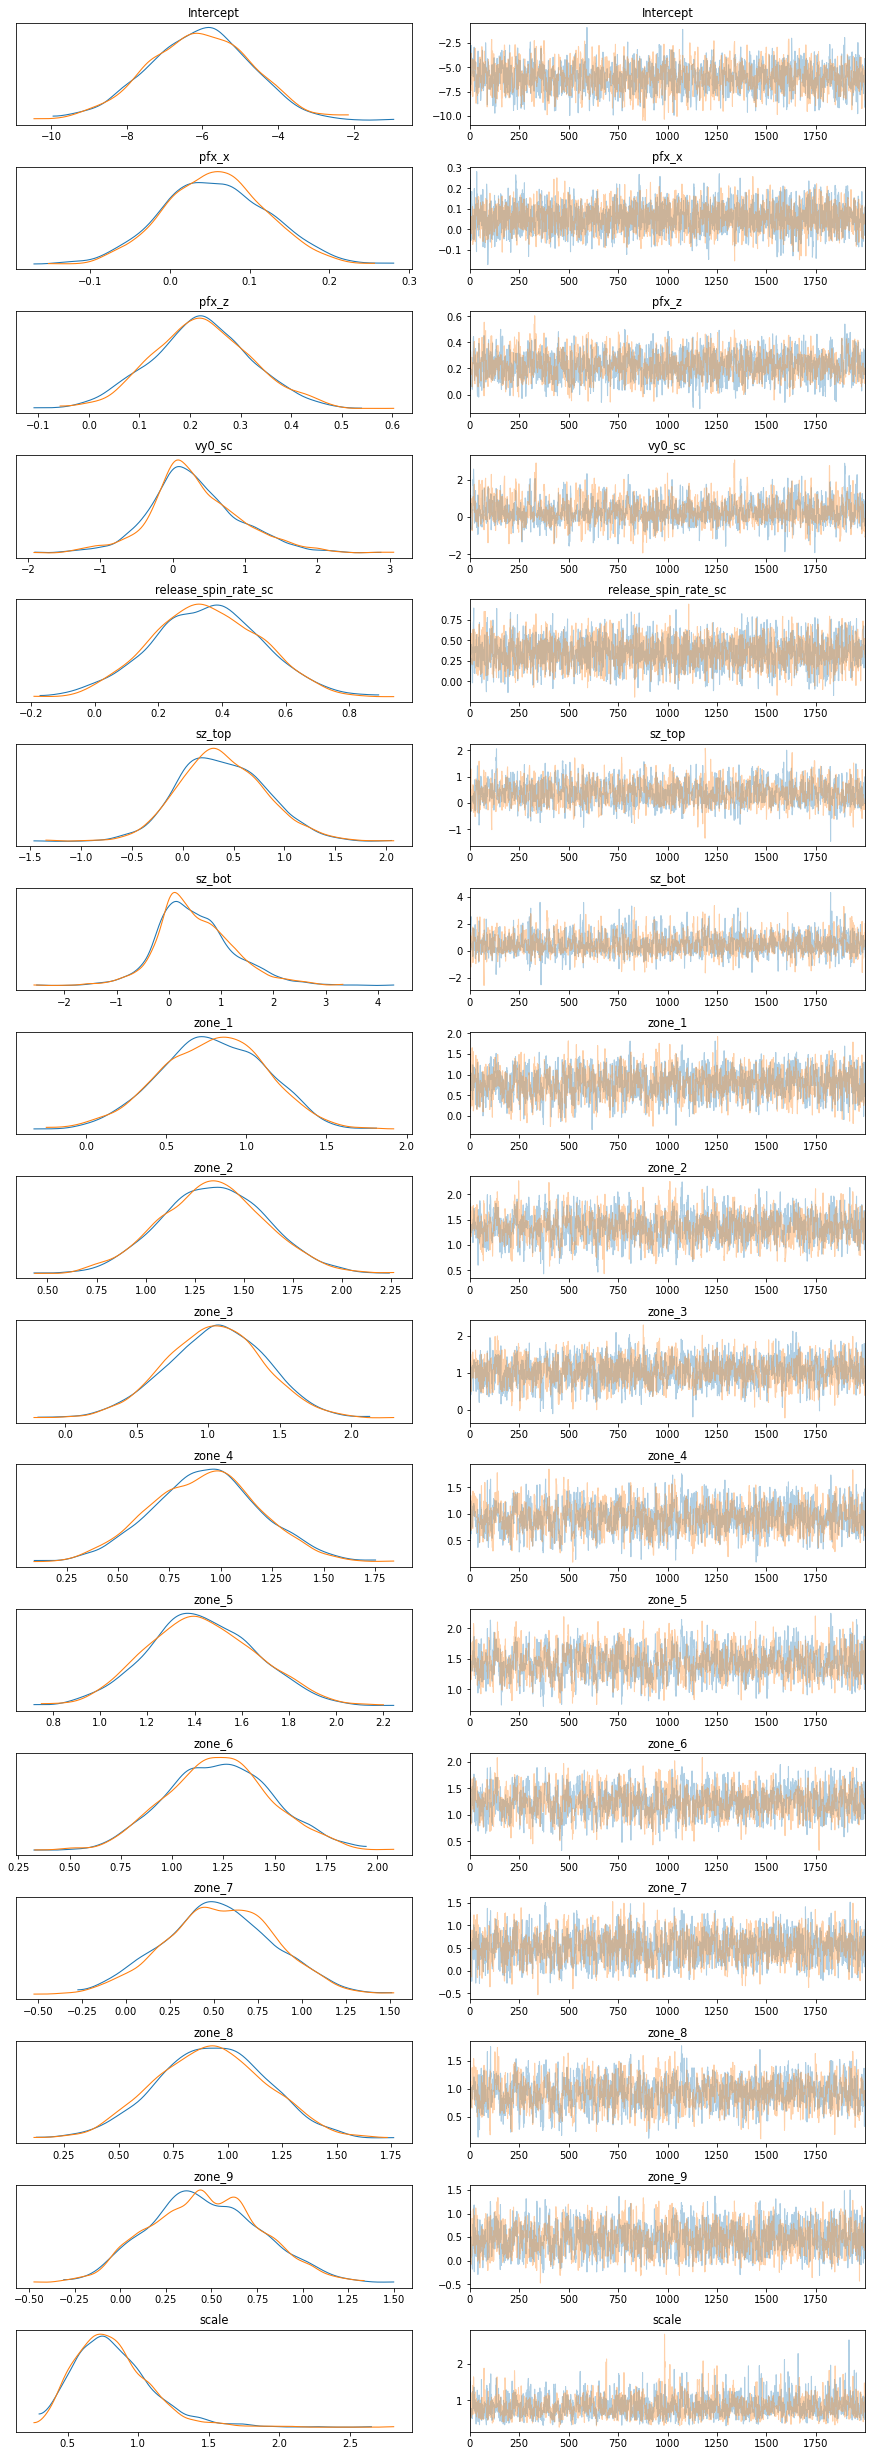

In [35]:
az.plot_trace(trace6)

In [36]:
print(waic1.round(2).to_latex())
print(waic2.round(2).to_latex())
print(waic3.round(2).to_latex())
print(waic4.round(2).to_latex())
print(trace6_sum.round(2).to_latex())

\begin{tabular}{llllllllll}
\toprule
{} & rank &     waic &   p\_waic &   d\_waic &    weight &       se &      dse & warning & waic\_scale \\
\midrule
contvars     &    0 & -1332.24 &   7.7669 &        0 &  0.561515 &  47.7544 &        0 &   False &        log \\
pitchdummies &    1 & -1333.27 &  7.86334 &  1.03351 &  0.412552 &  47.8829 &  3.84777 &   False &        log \\
base         &    2 & -1337.27 &  4.17819 &  5.03386 &  0.025933 &   47.637 &  3.01407 &   False &        log \\
\bottomrule
\end{tabular}

\begin{tabular}{llllllllll}
\toprule
{} & rank &     waic &   p\_waic &    d\_waic &       weight &       se &      dse & warning & waic\_scale \\
\midrule
zone\_topbot &    0 & -1299.81 &  14.9654 &         0 &     0.645448 &  45.6164 &        0 &   False &        log \\
zonedummies &    1 & -1300.73 &   13.634 &  0.918551 &     0.354552 &  45.6251 &  1.74454 &   False &        log \\
sz\_topbot   &    2 & -1336.63 &   5.0292 &   36.8249 &  5.50948e-09 &  44.4435 &  7.69359 & 

<AxesSubplot:xlabel='Log'>

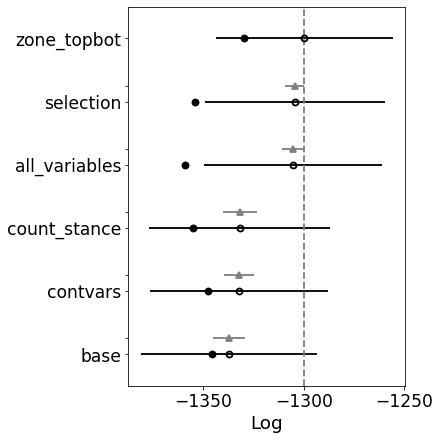

In [37]:
az.plot_compare(waic4)